### Statistical analysis ###

In [1]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.signal as ss
import sys
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(module_path)
import tools.data_reader_apd as dr_a
import tools.data_reader_case as dr_c
import tools.data_reader_wesad as dr_w
import tools.data_reader_popane as dr_p
import tools.display_tools as dt
import train

c:\Users\zhoux\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE
] + \
train.Metrics.STATISTICAL

temp_a, _ = train.Train_APD.get_apd_data_ranking([train.Metrics.BPM], phases=dr_a.Phases.PHASES_LIST, normalize=False)
idx = temp_a[temp_a["bpm"] > 200].index 
invalid_apd_subjects = set(temp_a["subject"].iloc[idx].tolist())
idx = temp_a[temp_a["bpm"] < 35].index 
invalid_apd_subjects.update(set(temp_a["subject"].iloc[idx].tolist()))

In [12]:
# LOAD FEATURES AND LABELS
importlib.reload(dr_a)
importlib.reload(dr_p)
importlib.reload(dr_w)
importlib.reload(dt)
importlib.reload(train)

threshold = "fixed"

# APD
phases = [
    "Baseline_Rest", 
    "BugBox_Relax", "BugBox_Anticipate", "BugBox_Exposure", "BugBox_Break",
    "Speech_Relax", "Speech_Anticipate", "Speech_Exposure", "Speech_Break"
]
apd_label_type = None
x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, verbose=False, anxiety_label_type=apd_label_type, threshold=threshold, normalize=True, standardize=False)
# drop subjects with noisy data
x = x[~x["subject"].isin(invalid_apd_subjects)]
y = y[~y["subject"].isin(invalid_apd_subjects)]
x = pd.concat([x, y], axis=1)

apd_metric_dfs = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    phase_df = phase_df.drop("phaseId", axis=1).reset_index(drop=True)
    apd_metric_dfs[phases[i]] = phase_df

# WESAD
phases = dr_w.Phases.PHASE_ORDER
wesad_label_type = "stai"
x, y = train.Train_WESAD.get_wesad_data(metrics, phases, verbose=False, label_type=wesad_label_type, normalize=False, threshold=threshold, binary_labels=True)
x = pd.concat([x, y], axis=1)

wesad_metric_dfs = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    phase_df = phase_df.drop("phaseId", axis=1).reset_index(drop=True)
    wesad_metric_dfs[phases[i]] = phase_df

# CASE
phases = dr_c.CLIPS
case_label_type = "arousal"
x, y = train.Train_CASE.get_case_data(metrics, verbose=False, label_type=case_label_type, normalize=False, threshold=threshold, binary_labels=True)
x = pd.concat([x, y], axis=1)

case_metric_dfs = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    phase_df = phase_df.drop("phaseId", axis=1).reset_index(drop=True)
    case_metric_dfs[phases[i]] = phase_df



In [ ]:
importlib.reload(dr_a)
importlib.reload(dr_p)
importlib.reload(dr_w)
importlib.reload(dt)


statistics = {
    "mean": np.nanmean, 
    "median": np.nanmedian, 
    "std": np.nanstd, 
    "var": np.nanvar
}

# print("DATASET: APD " + "-"*30)
# apd_metric_stats = []
# for phase in list(apd_metric_dfs.keys()):
#     # print(f"APD PHASE: {phase}")
#     for stat in list(statistics.keys()):
#         phase_df = apd_metric_dfs[phase]
#         phase_df_0 = phase_df.loc[phase_df["label"] == 0]
#         phase_df_1 = phase_df.loc[phase_df["label"] == 1]

#         stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
#         stat_df_0.columns = metrics
#         stat_df_0.insert(0, "label", 0)
#         stat_df_0.insert(0, "statistic", stat)
#         stat_df_0.insert(0, "phaseId", phase_df["phaseId"][0])

#         stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
#         stat_df_1.columns = metrics
#         stat_df_1.insert(0, "label", 1)
#         stat_df_1.insert(0, "statistic", stat)
#         stat_df_1.insert(0, "phaseId", phase_df["phaseId"][0])

#         stat_df = pd.concat([stat_df_0, stat_df_1])
#         apd_metric_stats.append(stat_df)

# apd_metric_stats = pd.concat(apd_metric_stats, axis=0).reset_index(drop=True)
# print(apd_metric_stats)
# print(f"APD LABEL COUNTS: {apd_metric_stats['label'].value_counts()}")


# print("DATASET: WESAD " + "-"*30)
# wesad_metric_stats = []
# for phase in list(wesad_metric_dfs.keys()):
#     # print(f"WESAD PHASE: {phase}")
#     for stat in list(statistics.keys()):
#         phase_df = wesad_metric_dfs[phase]
#         phase_df_0 = phase_df.loc[phase_df["label"] == 0]
#         phase_df_1 = phase_df.loc[phase_df["label"] == 1]

#         stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
#         stat_df_0.columns = metrics
#         stat_df_0.insert(0, "label", 0)
#         stat_df_0.insert(0, "statistic", stat)
#         stat_df_0.insert(0, "phaseId", phase_df["phaseId"][0])

#         stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
#         stat_df_1.columns = metrics
#         stat_df_1.insert(0, "label", 1)
#         stat_df_1.insert(0, "statistic", stat)
#         stat_df_1.insert(0, "phaseId", phase_df["phaseId"][0])

#         stat_df = pd.concat([stat_df_0, stat_df_1])
#         wesad_metric_stats.append(stat_df)

# wesad_metric_stats = pd.concat(wesad_metric_stats, axis=0).reset_index(drop=True)
# print(wesad_metric_stats)
# print(f"WESAD LABEL COUNTS: {wesad_metric_stats['label'].value_counts()}")


print("DATASET: ASCERTAIN " + "-"*30)
asc_metric_stats = []
for phase in list(asc_metric_dfs.keys()):
    # print(f"ASCERTAIN PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = asc_metric_dfs[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df["phaseId"][0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df["phaseId"][0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        asc_metric_stats.append(stat_df)

asc_metric_stats = pd.concat(asc_metric_stats, axis=0).reset_index(drop=True)
print(asc_metric_stats)
print(f"ASCERTAIN LABEL COUNTS: {asc_metric_stats['label'].value_counts()}")

In [ ]:
# VISUALIZING LABELS

for i, phase in enumerate(list(apd_metric_dfs.keys())):
    phase_df = apd_metric_stats[apd_metric_stats["phaseId"] == i].reset_index(drop=True)
    print(phase_df)

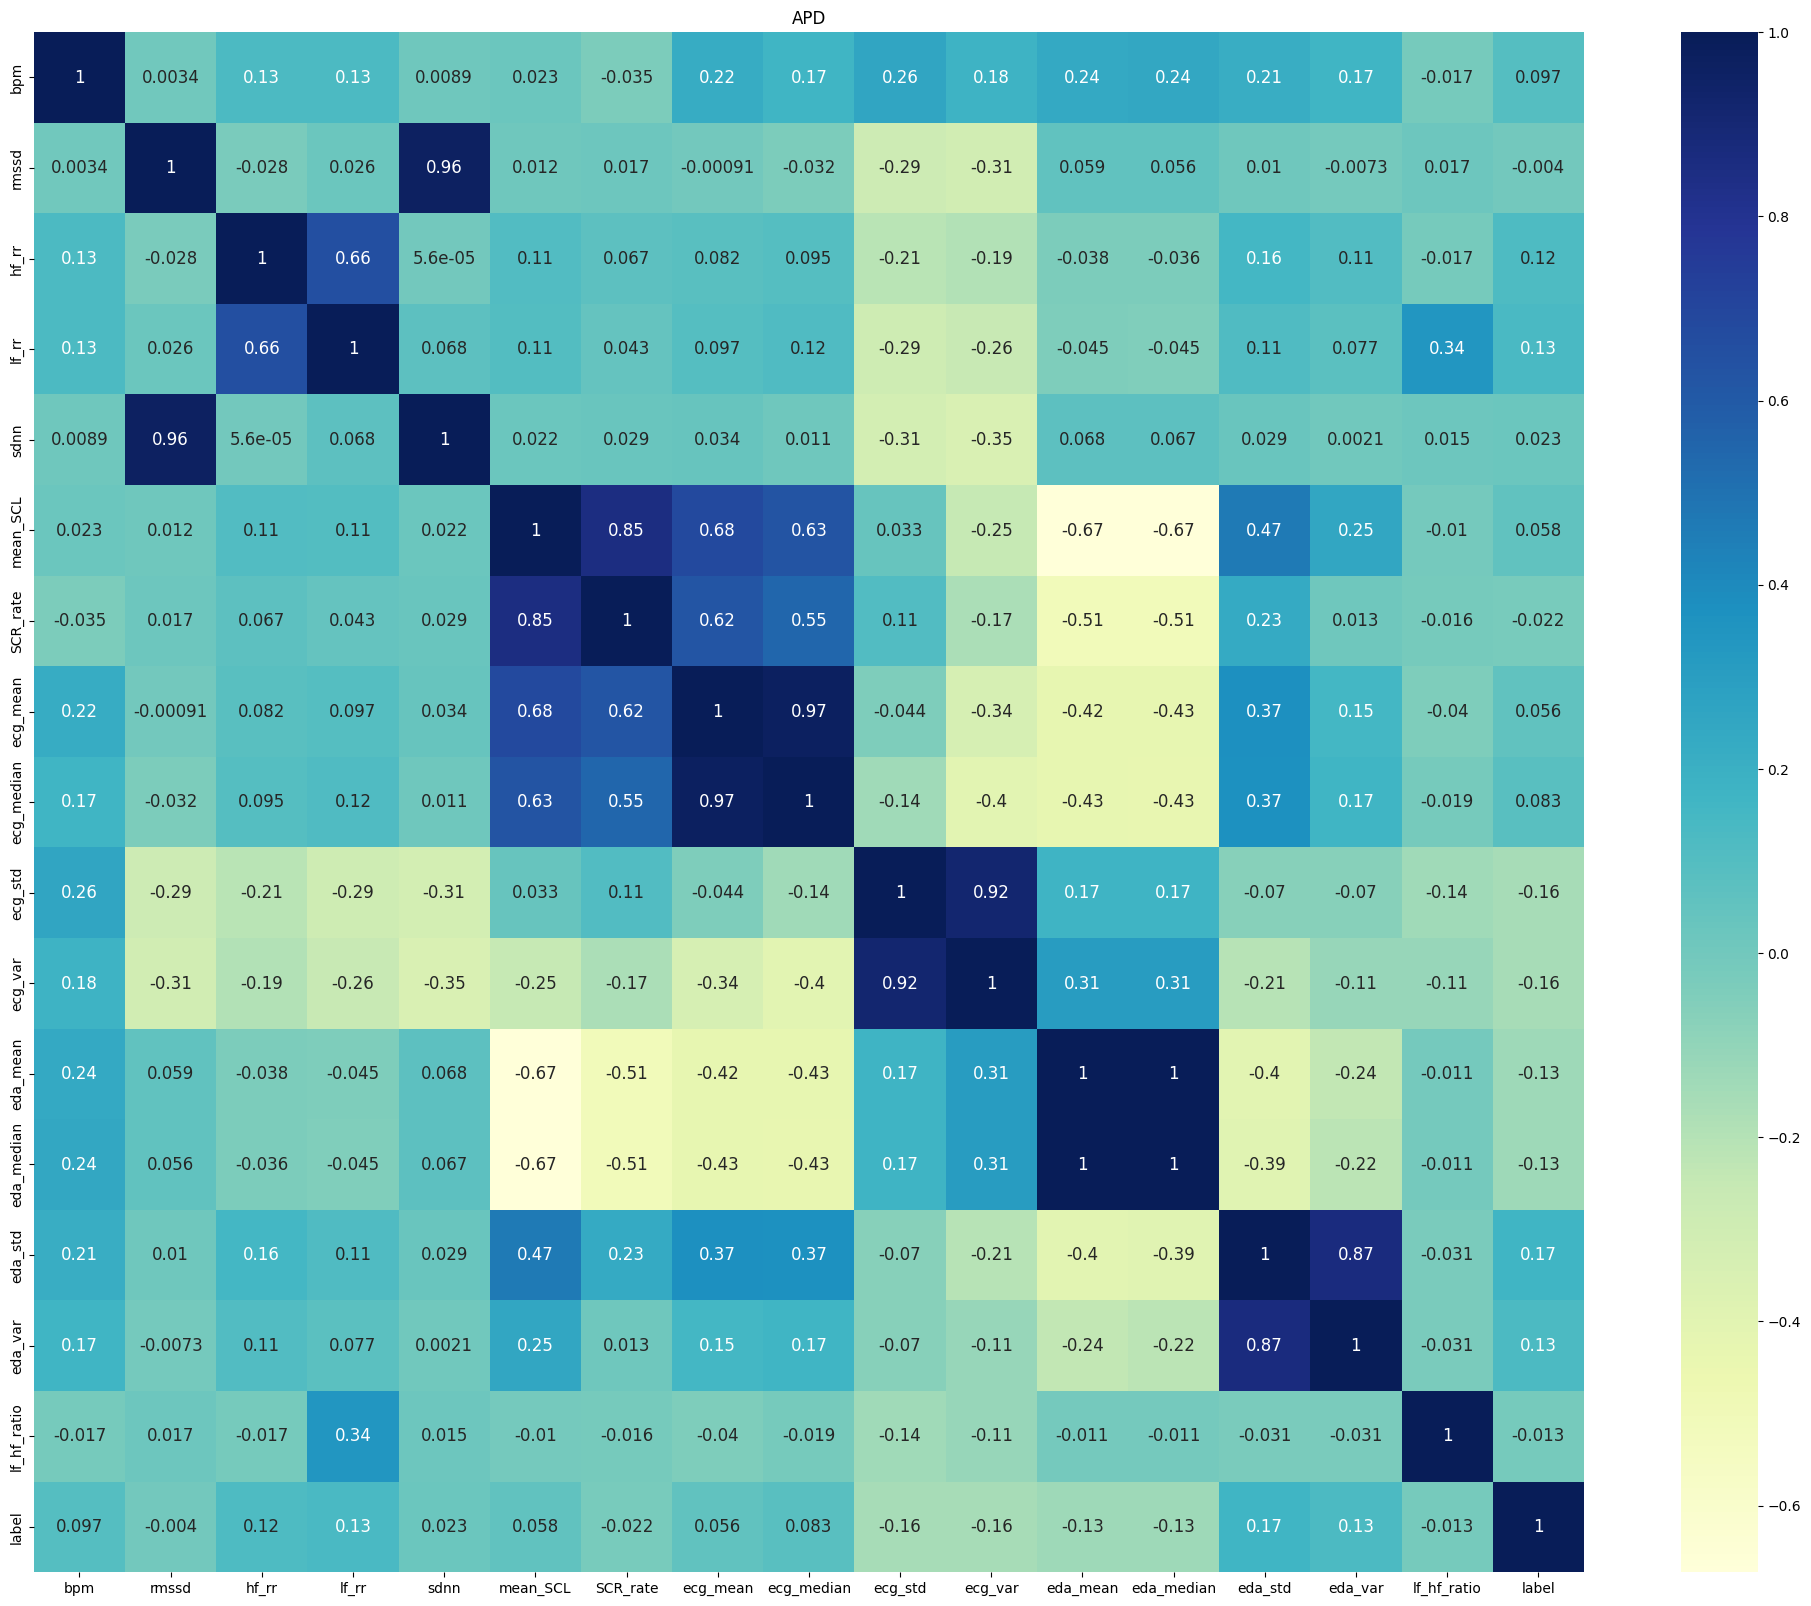

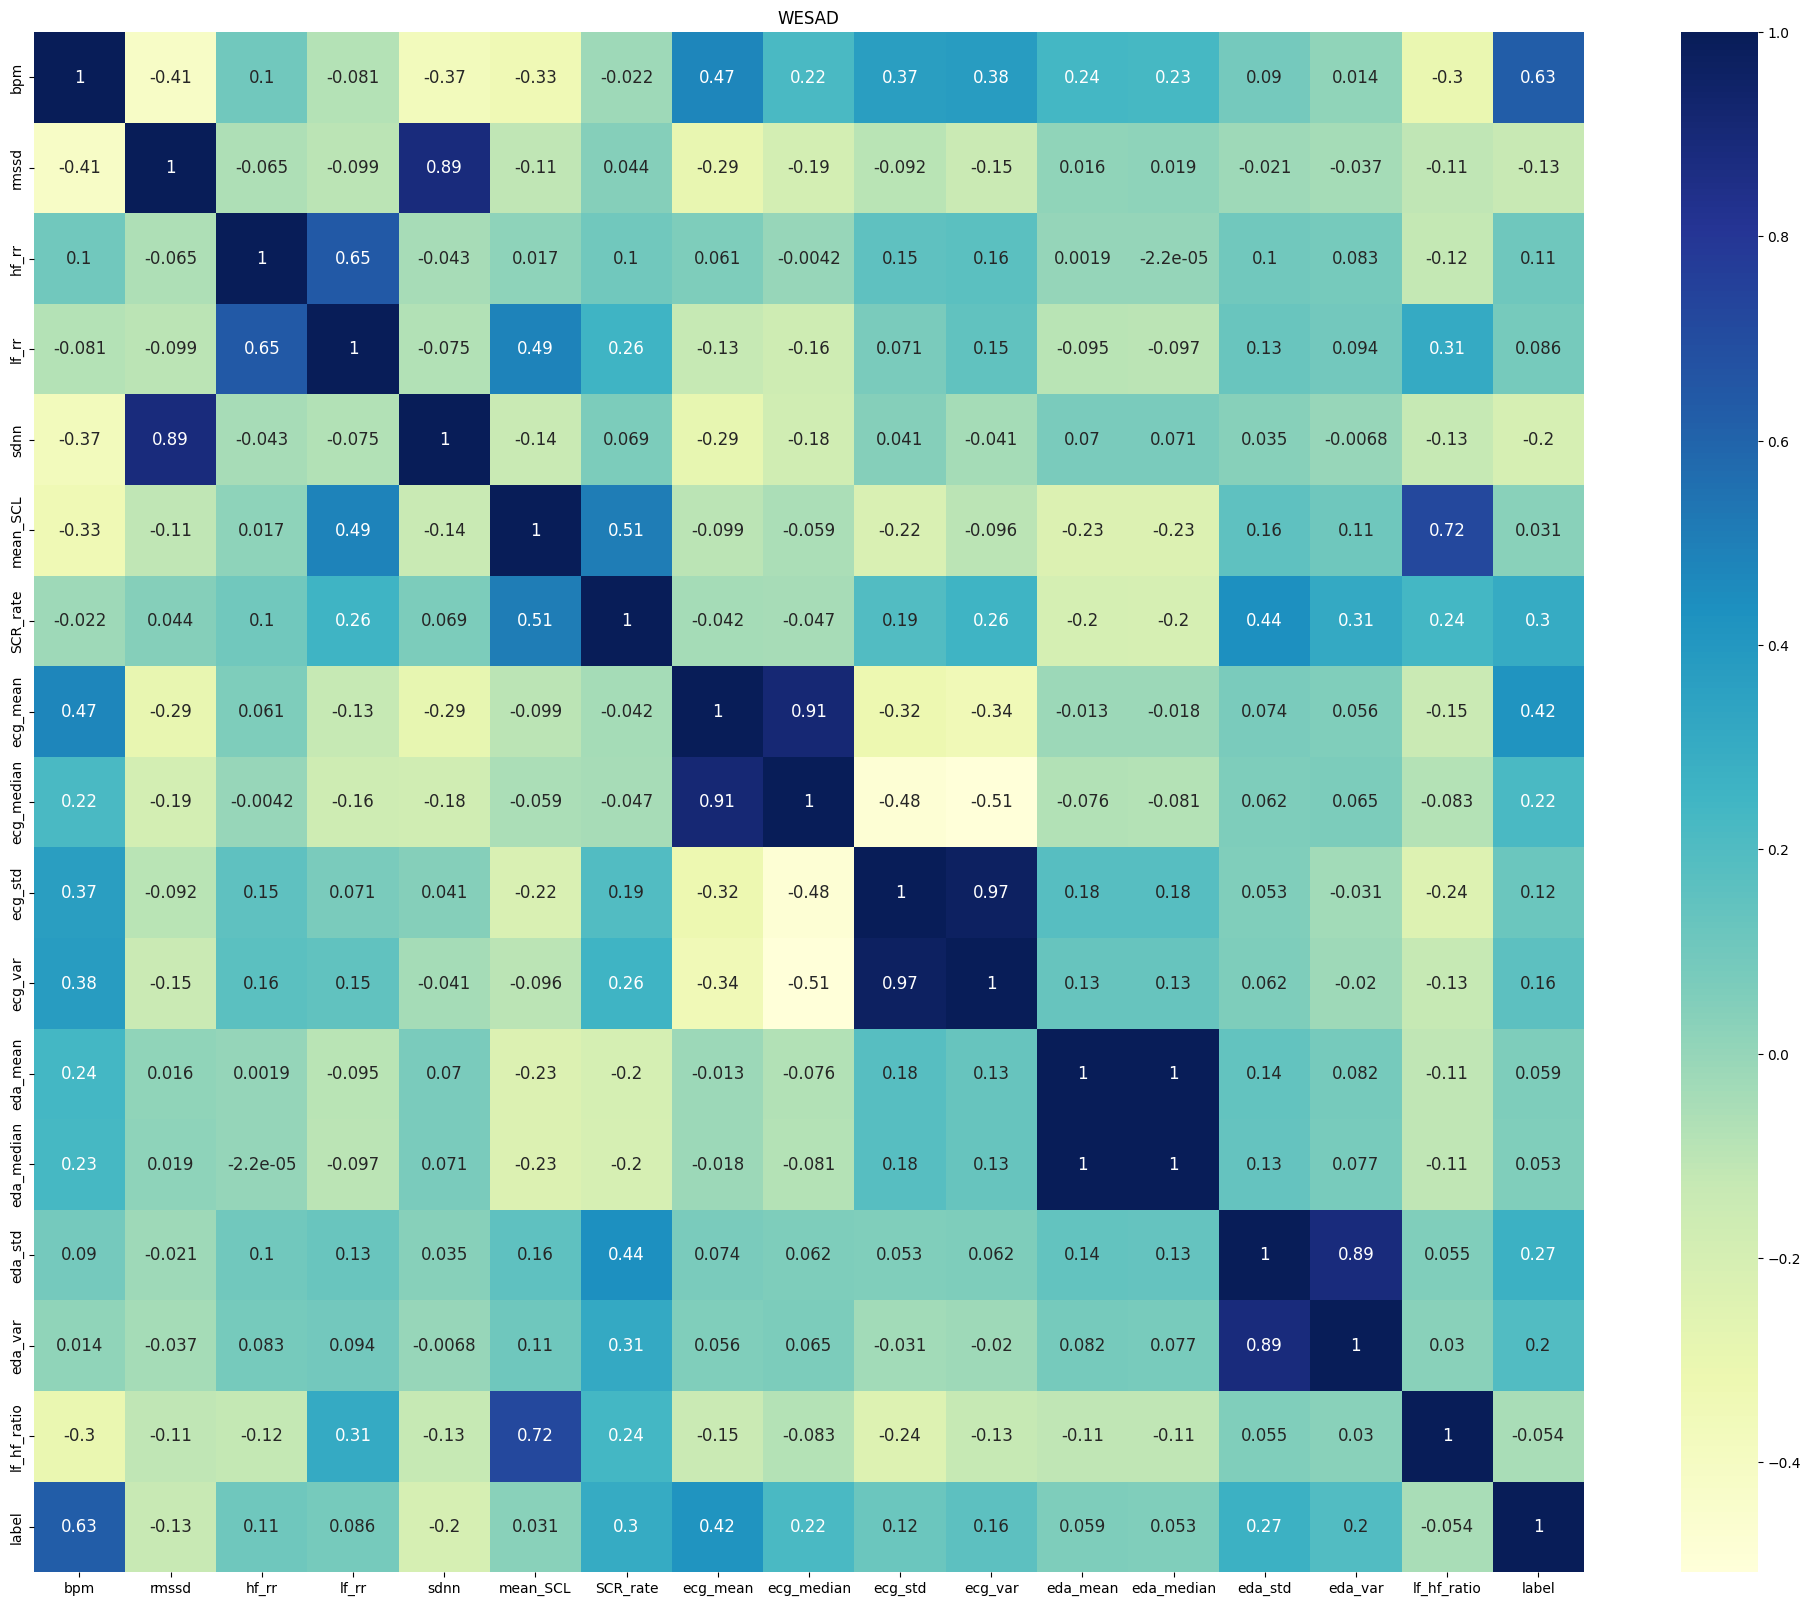

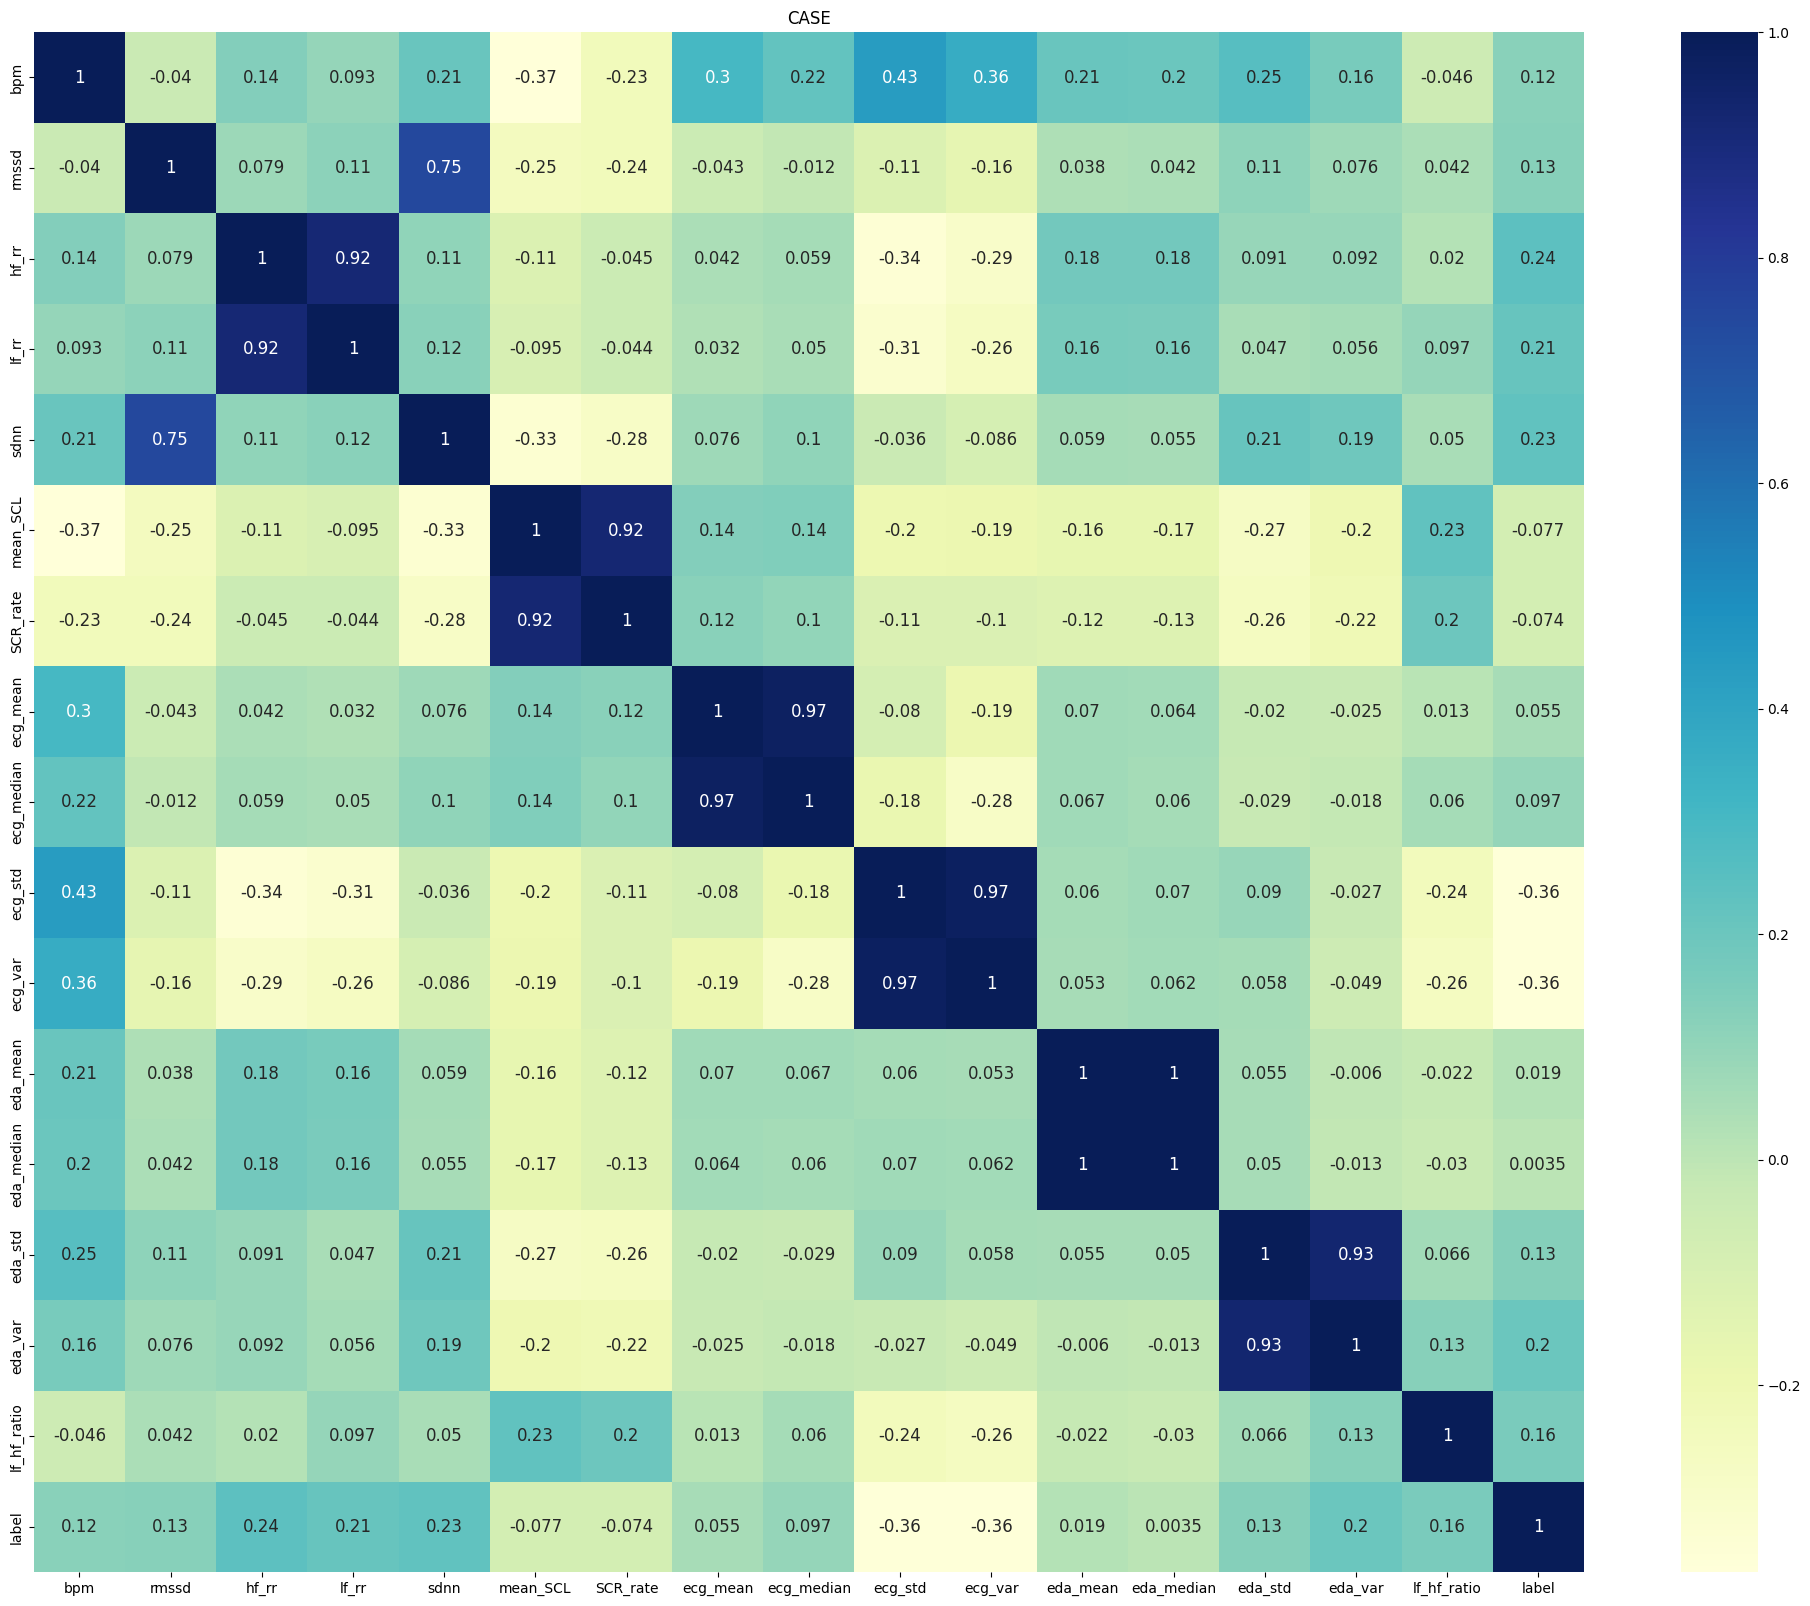

In [20]:
# VISUALIZING FEATURES -- correlation between mean of all features for each phase 
importlib.reload(dr_a)
importlib.reload(dr_p)
importlib.reload(dr_w)
importlib.reload(dt)
importlib.reload(train)
import seaborn as sb

threshold = "fixed"


phases = dr_a.Phases.PHASES_LIST
apd_label_type = None

# for i, phase in enumerate(phases):
    # print(f"{phase} " + "-"*30)
x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, verbose=False, anxiety_label_type=apd_label_type, threshold=threshold)
x = pd.concat([x, y], axis=1)
plt.figure(figsize=(25, 20))
heat_map = sb.heatmap(x.loc[:, metrics + ["lf_hf_ratio", "label"]].corr(), cmap="YlGnBu", annot=True, annot_kws={"fontsize":12})
# plt.title(f"APD {phase}, {threshold} label threshold")
plt.title(f"APD")
plt.show()


phases = dr_w.Phases.PHASE_ORDER
wesad_label_type = "stai"

# for i, phase in enumerate(phases):
    # print(f"{phase} " + "-"*30)
x, y = train.Train_WESAD.get_wesad_data(metrics, phases, verbose=False, label_type=wesad_label_type, normalize=True, threshold=threshold)
x = pd.concat([x, y], axis=1)
plt.figure(figsize=(25, 20))
heat_map = sb.heatmap(x.loc[:, metrics + ["lf_hf_ratio", "label"]].corr(), cmap="YlGnBu", annot=True, annot_kws={"fontsize":12})
# plt.title(f"WESAD {phase}, {threshold} label threshold")
plt.title(f"WESAD")
plt.show()


case_label_type = dr_c.SelfReports.AROUSAL

x, y = train.Train_CASE.get_case_data(metrics, verbose=False, label_type=case_label_type, normalize=True, threshold=threshold)
inds = pd.isnull(x).any(axis=1).to_numpy().nonzero()[0]
x = x.drop(labels=inds, axis=0)
y = y.drop(labels=inds, axis=0)
x = pd.concat([x, y], axis=1)
plt.figure(figsize=(25, 20))
heat_map = sb.heatmap(x.loc[:, metrics + ["lf_hf_ratio", "label"]].corr(), cmap="YlGnBu", annot=True, annot_kws={"fontsize":12})
plt.title(f"CASE")
plt.show()


# popane_studies = {
#     "Study1": dr_p.Study1.ALL,
#     "Study2": dr_p.Study2.ALL,
#     "Study3": dr_p.Study3.ALL,
#     # "Study4": dr_p.Study4.ALL,
#     "Study5": dr_p.Study5.ALL,
#     # "Study6": dr_p.Study6.ALL,
#     # "Study7": dr_p.Study7.ALL
# }
# popane_label_type = "affect"

# for study in popane_studies.keys():
#     phases = popane_studies[study]
#     # for i, phase in enumerate(phases):
#         # print(f"{phase} " + "-"*30)
#     try:
#         x, y = train.Train_POPANE.get_popane_data(study, metrics, phases, verbose=False, label_type=popane_label_type, threshold=threshold)
#     except Exception as e:
#         # print(f"Unable to load data for {study} {phase}")
#         print(f"Unable to load data for {study}")
#         continue
#     x = pd.concat([x, y], axis=1)
#     heat_map = sb.heatmap(x.loc[:, metrics + ["label"]].corr(), cmap="YlGnBu", annot=True, annot_kws={"fontsize":8})
#     # plt.title(f"POPANE {study}, {phase}, {threshold} label threshold")
#     plt.title(f"POPANE {study}, {threshold} label threshold")
#     plt.show()

In [ ]:
# CALCULATE MUTUAL INFORMATION -- APD
from sklearn.feature_selection import mutual_info_classif as MIC


print("APD MI")
for phase in apd_metric_dfs.keys():
    y = apd_metric_dfs[phase].loc[:, "label"].to_numpy()
    features = apd_metric_dfs[phase].loc[:, metrics + ["lf_hf_ratio"]].to_numpy()
    mi = MIC(features, y)
    print(mi)

print("WESAD MI")
for phase in wesad_metric_dfs.keys():
    y = wesad_metric_dfs[phase].loc[:, "label"].to_numpy()
    features = wesad_metric_dfs[phase].loc[:, metrics + ["lf_hf_ratio"]].to_numpy()
    mi = MIC(features, y)
    print(mi)

print("ASC MI")
for phase in asc_metric_dfs.keys():
    y = asc_metric_dfs[phase].loc[:, "label"].to_numpy()
    features = asc_metric_dfs[phase].loc[:, metrics + ["lf_hf_ratio"]].to_numpy()
    print(features)
    # mi = MIC(features, y)
    # print(mi)
